<a href="https://colab.research.google.com/github/ram130849/stock_price_prediction/blob/main/Walmart_Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 918.2/918.2 kB 18.2 MB/s eta 0:00:00


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA


from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima


from arch import arch_model
from arch.univariate import ARX, GARCH, StudentsT, Normal

In [3]:
import warnings        
# ignore filters
warnings.filterwarnings("ignore") # if there is a warning after some codes, this will avoid us to see them.
plt.style.use('ggplot')
pd.options.display.max_columns=100
%matplotlib inline

In [4]:
import zipfile
with zipfile.ZipFile('/content/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [5]:
df_store = pd.read_csv('/content/stores.csv')
df_features = pd.read_csv('/content/features.csv')

In [6]:
df_store.head(5)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [7]:
df_features.head(-5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8180,45,2013-05-24,67.11,3.627,3249.34,481.82,58.48,1183.23,1309.30,NaN,NaN,False
8181,45,2013-05-31,65.88,3.646,6474.49,411.38,77.06,9.38,4227.27,NaN,NaN,False
8182,45,2013-06-07,70.71,3.633,9977.82,744.29,80.00,4825.71,3597.34,NaN,NaN,False
8183,45,2013-06-14,70.01,3.632,2471.44,517.87,348.54,2612.33,3459.39,NaN,NaN,False


In [8]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [9]:
train.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [10]:
test.head(5)

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [11]:
train['Store'].nunique()

45

In [12]:
train['Dept'].nunique()

81

In [13]:
# merging 3 different sets
df = train.merge(df_features, on=['Store', 'Date'], how='inner').merge(df_store, on=['Store'], how='inner')
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday_x   421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  IsHoliday_y   421570 non-null  bool   
 15  Type          421570 non-null  object 
 16  Size          421570 non-null  int64  
dtypes: bool(2), float64(10), int64(3), object(2)
mem

In [15]:
df.drop(['IsHoliday_y'], axis=1,inplace=True)
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True)

In [16]:
df.shape

(421570, 16)

In [17]:
store_dept_table = pd.pivot_table(df, index='Dept', columns='Store',values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

Store,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45
Dept,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,30777.980769,7328.621049,36979.940070,9774.553077,23867.553776,9542.801259,14789.827343,11846.558252,39925.138951,18860.911958,17330.087622,47020.455455,30611.783357,13845.747832,11352.479371,22801.609161,21988.356224,21504.029161,40545.473217,14950.049231,21493.271119,33186.460559,18859.023357,20145.897483,19402.762937,30437.976224,20180.453986,15504.699580,9788.376643,17356.652448,22852.639510,2379.086573,19947.573077,17082.647902,2239.227413,11024.235874,6923.538531,21925.021189,18794.578811,23205.259930,10375.148392,7549.109021,8049.992308,17745.916014
2,46102.090420,65912.922517,16841.775664,93639.315385,12317.953287,50269.437273,22603.690769,35729.821748,24969.477413,109795.291469,57114.326224,74494.846224,76339.960000,77704.857972,26317.410769,23549.144965,42231.844406,63665.139510,50841.072937,78251.249930,47780.599161,53361.851888,70522.580140,40797.169301,36871.310559,27398.030979,79001.049161,57751.274336,25181.662727,12974.464476,58512.131538,50323.497343,7471.425105,34916.225874,45578.456224,13416.025664,16511.446224,10986.172657,67338.429371,26702.705175,48349.828951,15976.902448,20722.851469,9377.273007,35800.912448
3,13150.478042,17476.563357,5509.300769,19012.491678,4101.085175,16806.638811,8633.536923,10683.305105,7497.356783,32086.181469,17628.778671,17535.251678,26116.623706,19418.273986,10470.811958,7635.427273,19278.955035,16392.980490,18414.224476,15490.971259,14607.126923,13150.979510,19912.564755,11825.589021,11788.130979,7357.400769,20226.734615,12562.223287,7995.955804,739.981888,10616.675944,15472.540140,283.950140,8377.376434,14308.382797,381.324266,1297.862028,498.700210,20569.701608,6489.030350,17021.833357,814.451189,999.648881,571.016713,9508.014965
4,36964.154476,45607.666573,8434.186503,56603.400140,9860.806783,34187.366503,14950.518601,21089.309301,17165.947762,48579.826364,28837.744545,26673.788182,42563.275455,52936.323287,13082.172448,14748.078112,23961.357273,26775.207203,31365.545315,51456.376643,19354.728042,32104.132378,27324.303077,29245.357552,20351.455455,24498.113846,43596.933916,27980.817203,14326.216224,13216.100909,34848.899231,28137.154965,6107.616014,19791.509021,19495.631119,9873.505105,17614.013636,10669.501329,44807.515105,24386.750559,30538.574895,14885.264755,18227.382168,7403.959580,24229.873147
5,24257.941119,30555.315315,11695.366573,45668.406783,6699.202238,34465.307622,13860.350490,19838.849231,19282.746014,58373.460280,36663.363916,27756.204615,56786.934755,33468.325035,16465.706993,13494.538671,27082.325594,22933.954965,28759.223846,41647.786503,16090.874545,23187.335105,36895.869021,29178.058811,12422.996434,17589.532587,28059.038252,28221.618392,12931.821259,405.565944,18715.630769,20748.371888,112.728310,21633.900559,24858.433706,314.753982,1137.631189,397.418322,24043.436783,17689.671678,25513.943776,1052.296783,575.417326,960.670490,16107.063077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,120772.062168,143588.751888,15745.528252,147236.473706,19340.693986,89208.786294,34208.097273,62951.463706,29575.050769,73344.654685,77487.279091,43405.853357,136844.834056,144446.932517,27291.017133,27385.769231,50614.958462,57668.251748,97240.503566,150613.955385,40379.295175,57868.571119,54199.088322,93927.992098,43991.147692,70236.827622,119519.410909,96322.113846,30980.395594,45456.508322,106696.019231,84695.234196,27022.949161,69245.187972,43286.536993,39735.688741,51410.551119,41793.649021,103036.757133,66572.881259,88666.468392,61205.272308,72883.223287,31100.185175,52896.166643
96,33251.831639,34319.063846,3934.540000,38346.573077,5985.671119,30450.542238,1123.383217,16.986667,3596.107762,11079.676643,21685.298811,6.441176,9165.0799

In [18]:
# fill missing values in markdown columns with 0
# NOTE: inplace won't work for MULTI-columns
list_cols = ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]
df[list_cols] = df[list_cols].fillna(0)

In [19]:
# df = df.loc[df['Weekly_Sales'] > 0]
# # Checking whether any null values existing in the dataframe
# sum(pd.isna(df.Weekly_Sales)==True)
df.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64

In [20]:
df.shape

(421570, 16)

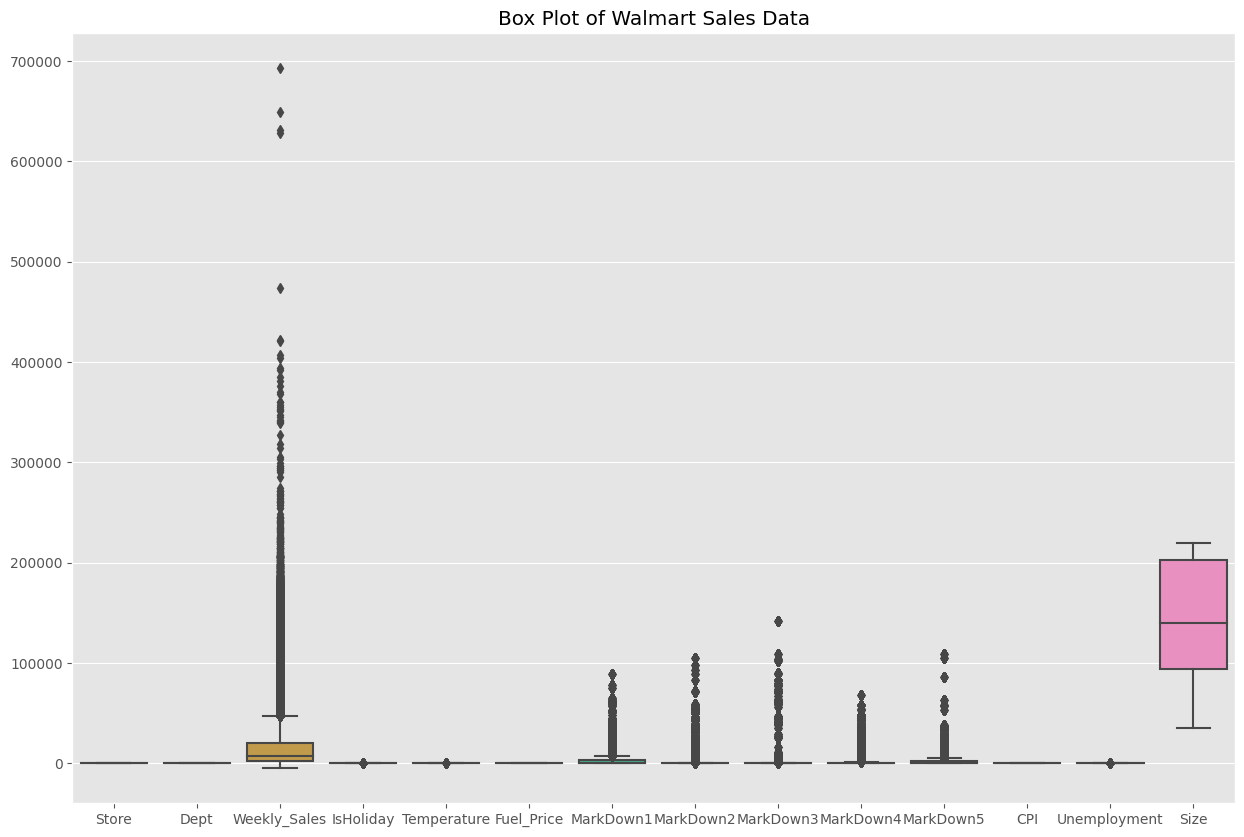

In [21]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df)
plt.title('Box Plot of Walmart Sales Data')
plt.show()

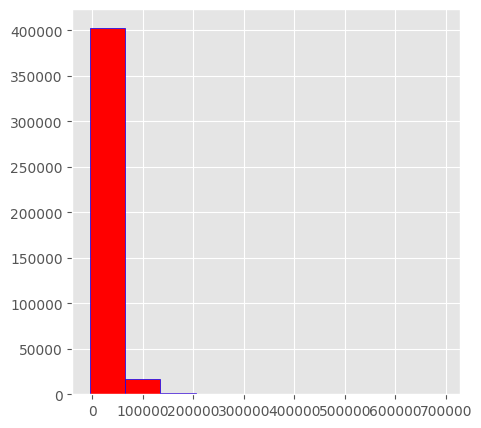

In [22]:
# Data is highly right skewed
plt.figure(figsize=(5,5))
plt.hist(df['Weekly_Sales'],facecolor='red',edgecolor='blue')
plt.show()

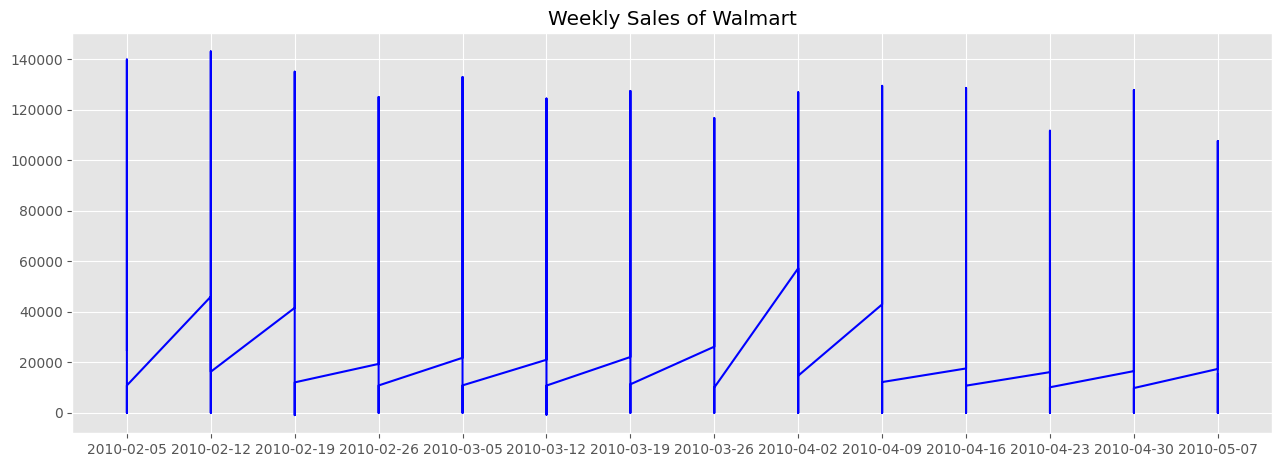

In [23]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_axes([0,0,1,1])
ax1.set_title('Weekly Sales of Walmart')
ax1.plot(df['Date'][:1000],df['Weekly_Sales'][:1000],color='blue')
plt.show()

print('Store Type value Counts')
print(df['Type'].value_counts())
print('Unemployment value Counts')
print(df['Is'].value_counts())

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

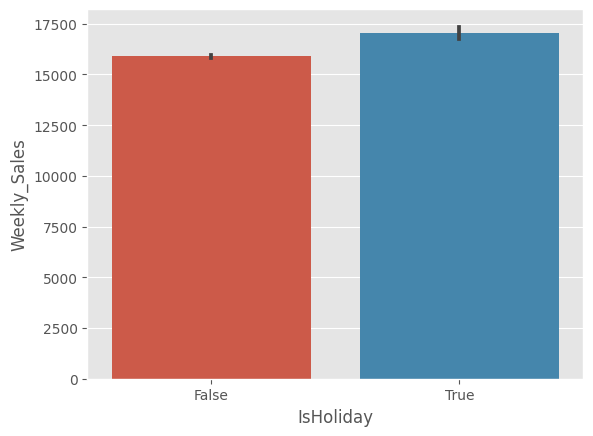

In [24]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df)

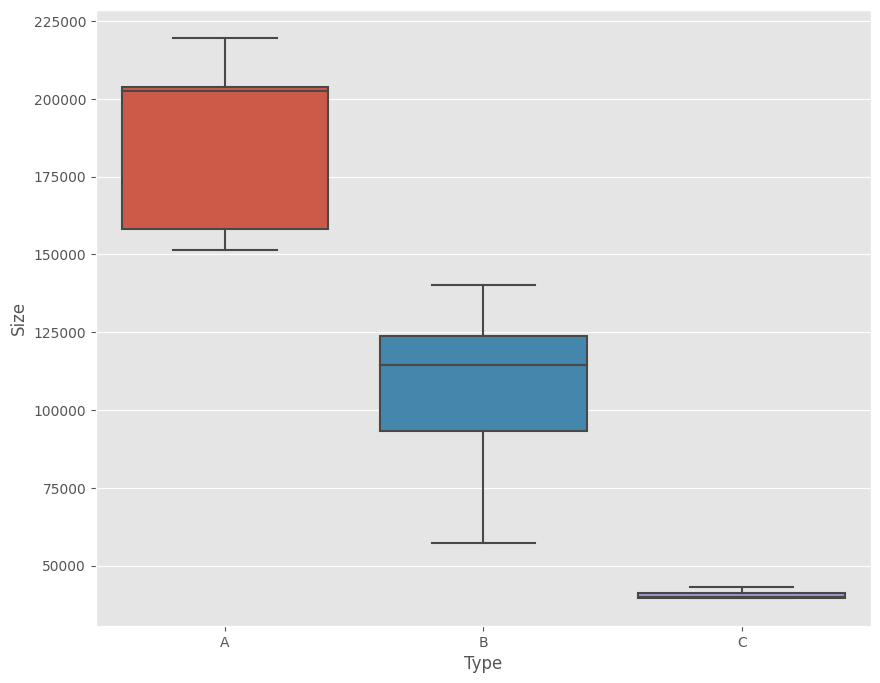

In [25]:
plt.figure(figsize=(10,8)) # To see the type-size relation
fig = sns.boxplot(x='Type', y='Size', data=df, showfliers=False)

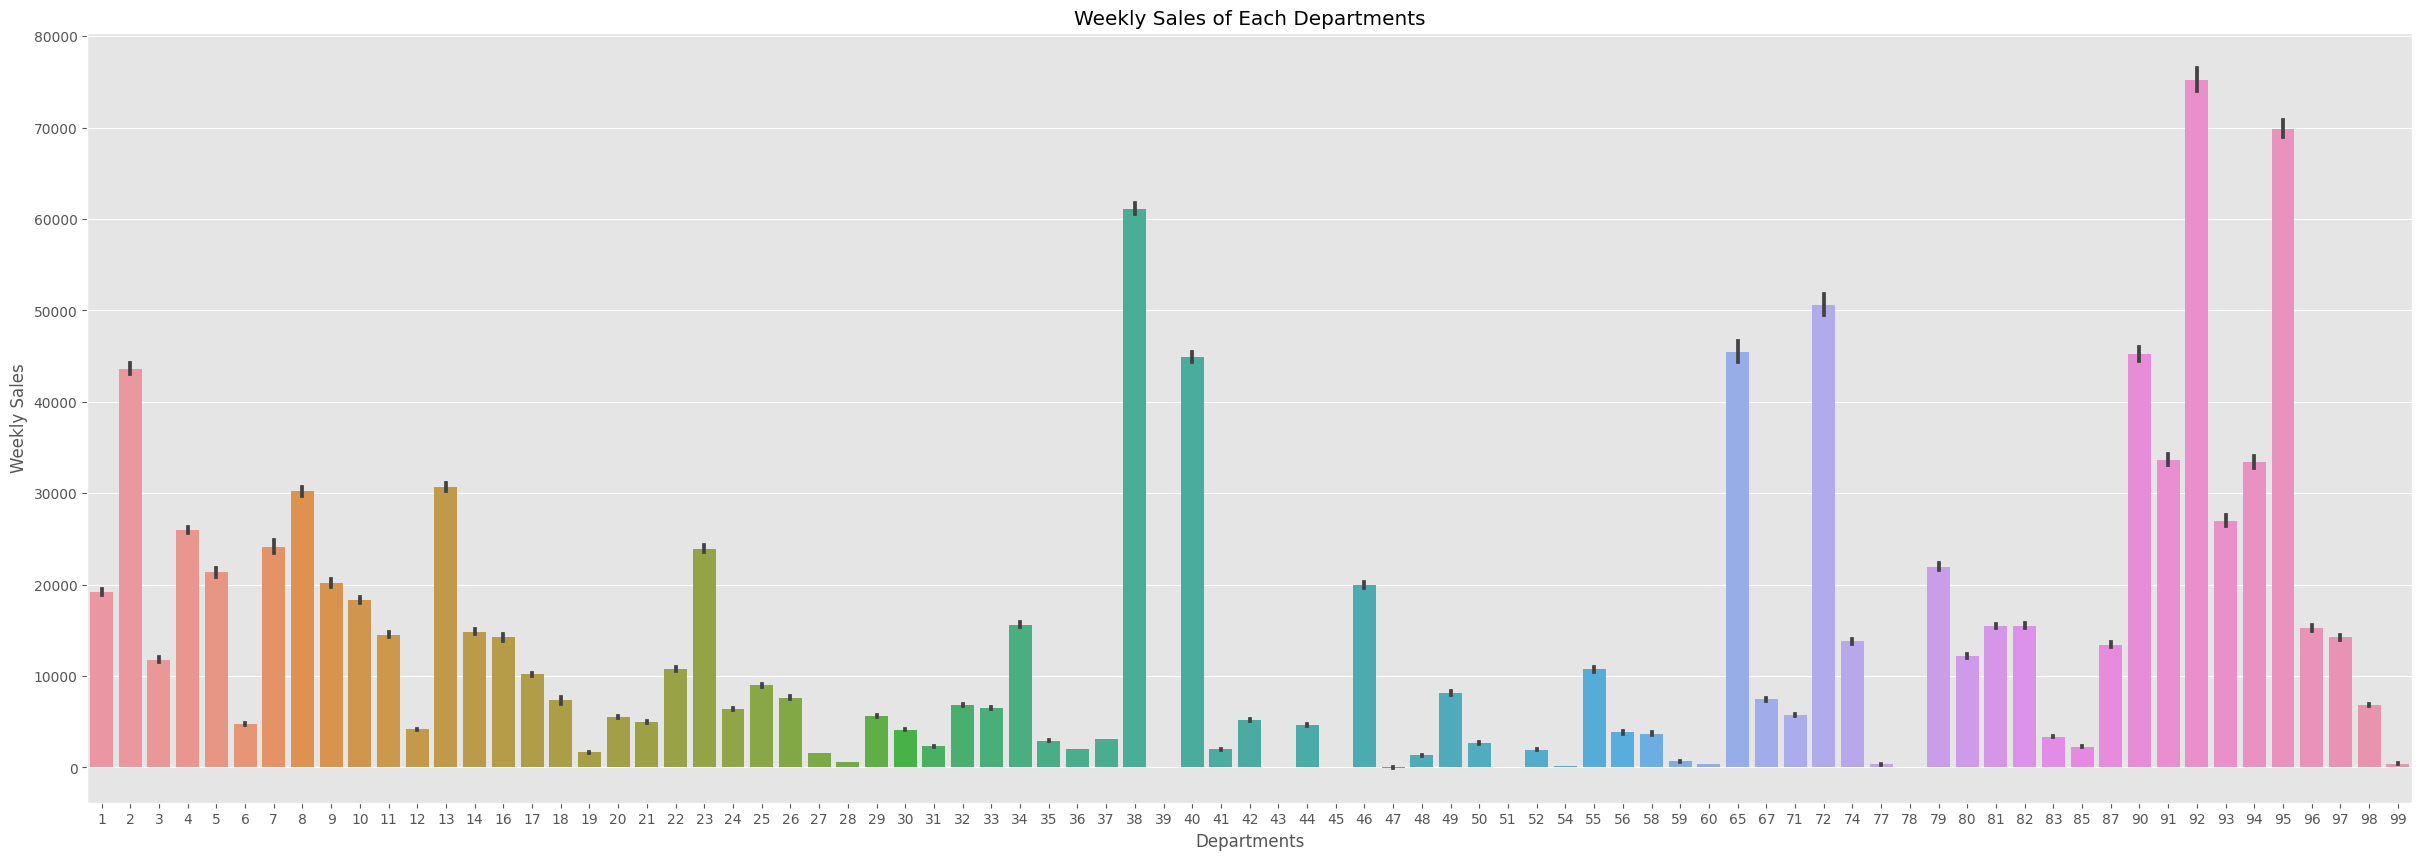

In [26]:
plt.figure(figsize=(30,10))
fig = sns.barplot(x='Dept', y='Weekly_Sales', data=df)
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales of Each Departments')
plt.show()

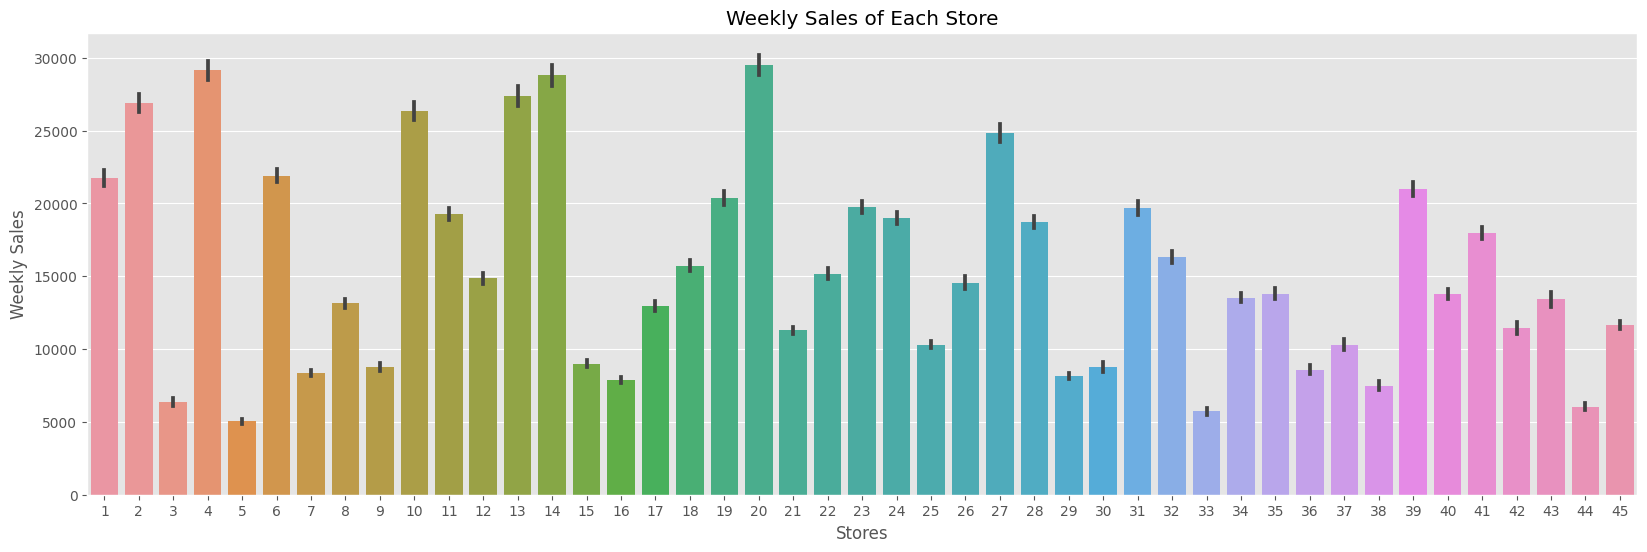

In [27]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=df)
plt.xlabel('Stores')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales of Each Store')
plt.show()

In [28]:
df["Date"] = pd.to_datetime(df["Date"]) # convert to datetime
df['week'] =df['Date'].dt.week
df['month'] =df['Date'].dt.month 
df['year'] =df['Date'].dt.year

In [29]:
df.groupby('month')['Weekly_Sales'].mean()

month
1     14126.075111
2     16008.779217
3     15416.657597
4     15650.338357
5     15776.337202
6     16326.137002
7     15861.419650
8     16062.516933
9     15095.886154
10    15243.855576
11    17491.031424
12    19355.702141
Name: Weekly_Sales, dtype: float64

In [30]:
df.groupby('year')['Weekly_Sales'].mean()

year
2010    16270.275737
2011    15954.070675
2012    15694.948597
Name: Weekly_Sales, dtype: float64

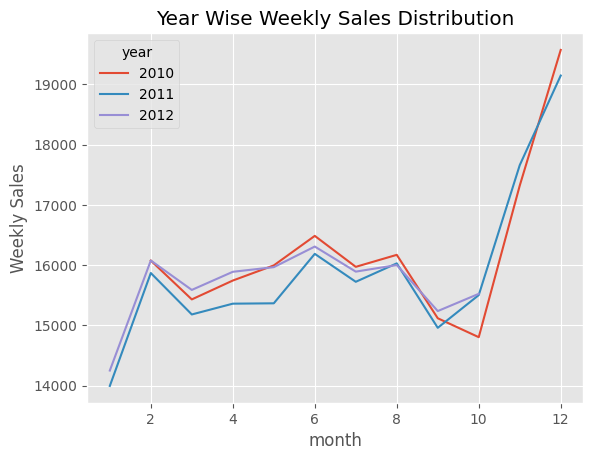

In [31]:
monthly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()
plt.ylabel('Weekly Sales')
plt.title('Year Wise Weekly Sales Distribution')
plt.show()

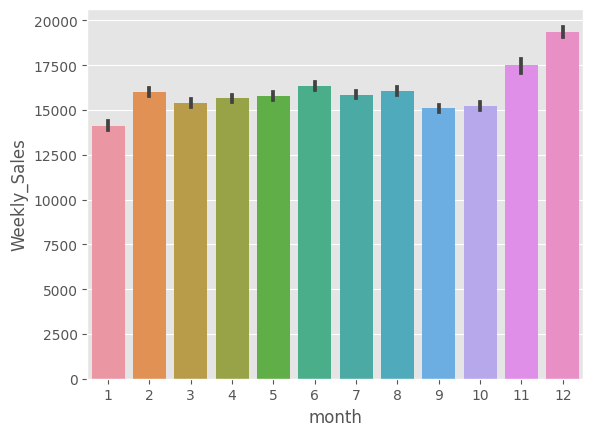

In [32]:
fig = sns.barplot(x='month', y='Weekly_Sales', data=df)

In [33]:
df.groupby('month')['Weekly_Sales'].mean().sort_values(ascending=False).head()

month
12    19355.702141
11    17491.031424
6     16326.137002
8     16062.516933
2     16008.779217
Name: Weekly_Sales, dtype: float64

<Axes: xlabel='week'>

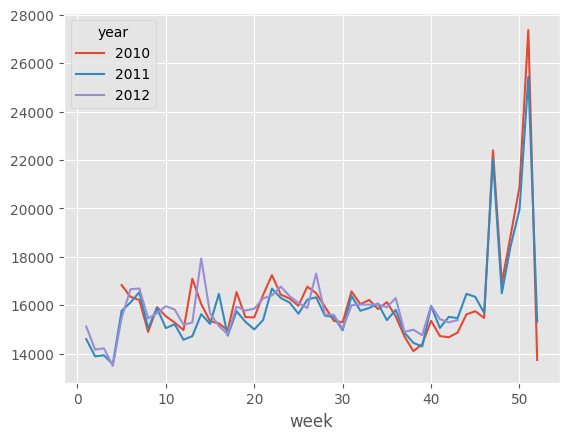

In [34]:
weekly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()

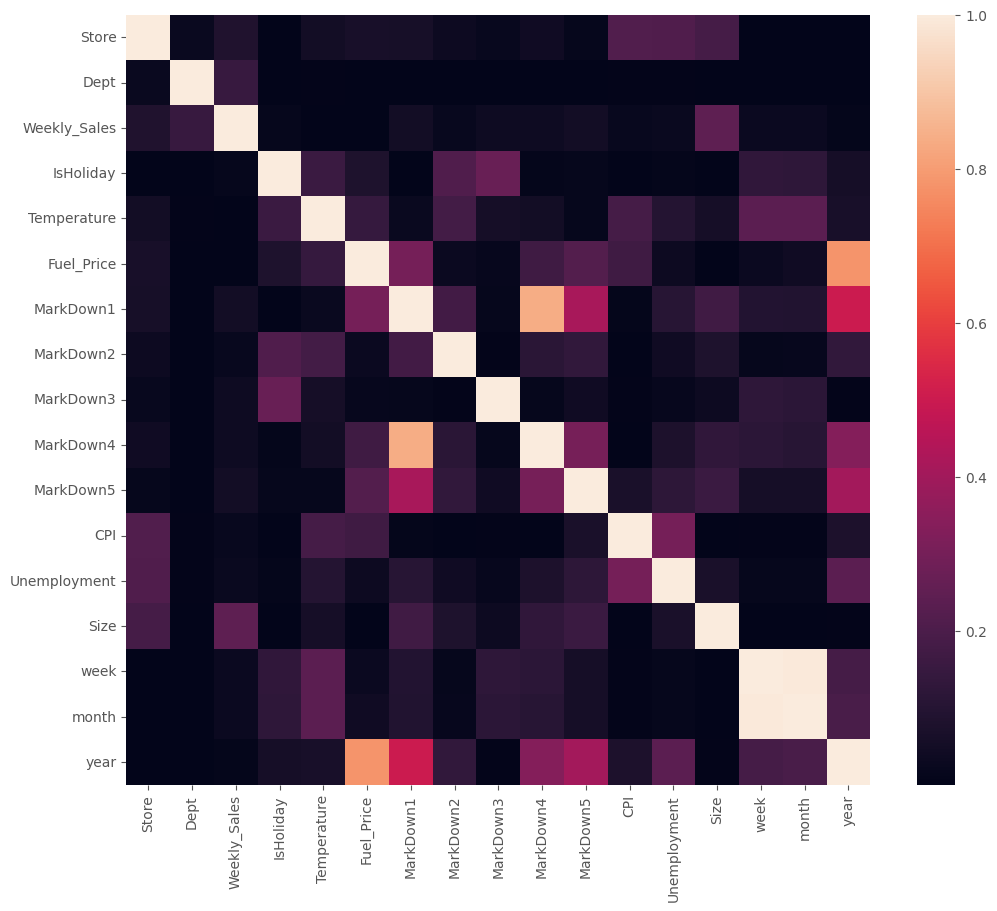

In [36]:
plt.figure(figsize = (12,10))
sns.heatmap(df.corr().abs())    # To see the correlations
plt.show()

Temperature, Fuel Price, unemployment, CPI have no significant effect on weekly sales, so I will drop them. Also, Markdown 4 is highly correlated with Markdown 1. So, I will drop them also. It can create multicollinearity problem, maybe. So, first I will try without them.

In [40]:
drop_col = ['Temperature','MarkDown4','Fuel_Price','CPI','Unemployment']
df.drop(drop_col, axis=1, inplace=True)

In [41]:
df.to_csv('clean_data.csv')

In [42]:
# Size and type are highly correlated with weekly sales
df = df.sort_values(by='Date', ascending=True)

In [43]:
train_data = df[:int(0.7*(len(df)))] # taking train part
test_data = df[int(0.7*(len(df))):] # taking test part

target = "Weekly_Sales"
used_cols = [c for c in df.columns.to_list() if c not in [target]] # all columns except weekly sales

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

[]

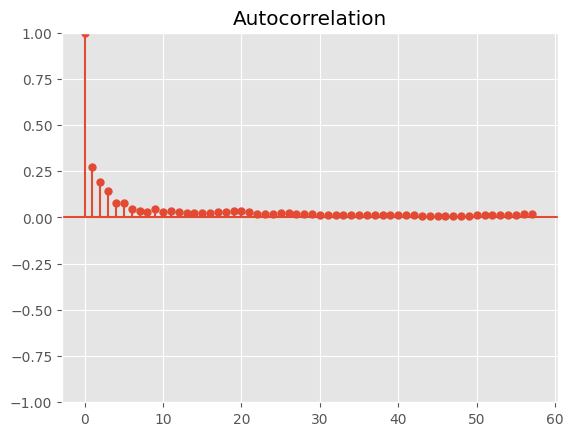

In [47]:
plot_acf(df['Weekly_Sales'])
plt.plot()

[]

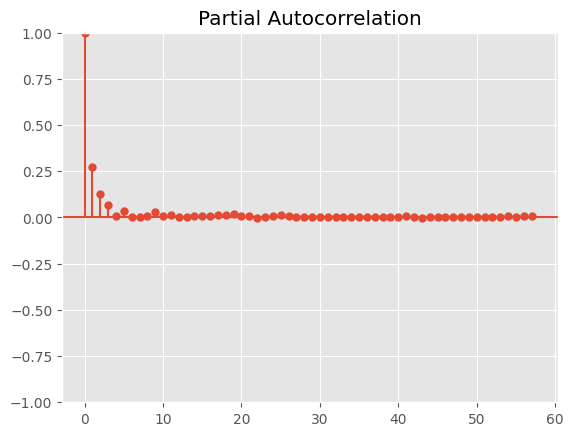

In [48]:
plot_pacf(df['Weekly_Sales'])
plt.plot()

In [39]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()